## Analysis of Loan duration and late returns
This notebook is used to explore possible correlations between loan duration and late returns.

Most of the analysis is done with media types with at least 1000 borrowings. (Adjust the `MIN_BORROWINGS_PER_MEDIA_TYPE` variable in `03_data_cleaning.ipynb`)

Initialization
- import all dependencies
- read all borrowings from "borrowings" csv-file

In [7]:
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import plotly.express as px
import statsmodels.api as sm
from utils import setup_pandas, setup_plotting, log_pearson_spearman

input_file = Path('../dat/processed/borrowings_2019_2025_cleaned.csv')

data_frame = pd.read_csv(
    input_file,
    sep=';',
    quotechar='"',
    encoding='utf-8'
)

print(data_frame.shape)
data_frame.head()

(1888669, 21)


,issue_id,Ausleihdatum/Uhrzeit,Rückgabedatum/Uhrzeit,Leihdauer,Anzahl_Verlängerungen,Verspätet,Tage_zu_spät,Sammlungszeichen/CCODE,Medientyp,Barcode,...,Autor,ISBN,Interessenkreis,Benutzerkategorie,Benutzer-Systemnummer,source_year,late_bool,open_days_leihdauer,max_allowed_open_days,weird_loan
0,56565,2019-01-02 00:00:00,2019-03-06 07:09:36,63.0,1,Nein,0.0,esac,Sachbuch,18143906,...,NaN,9783831904525,NaN,MPA,50.0,2019,False,0.0,56,False
1,56566,2019-01-02 00:00:00,2019-03-06 07:09:38,63.0,1,Nein,0.0,esac,Sachbuch,18184110,...,"Bruschke, Gerhard",9783734205736,NaN,MPA,50.0,2019,False,0.0,56,False
2,56567,2019-01-02 00:00:00,2019-03-06 07:09:31,63.0,1,Nein,0.0,esac,Sachbuch,17202121,...,"Fründt, Hans-Jürgen",9783831730735,NaN,MPA,50.0,2019,False,0.0,56,False
3,56574,2019-01-07 00:00:00,2019-02-09 12:14:54,33.0,0,Nein,0.0,eslfantasy,Belletristik,15138046,...,"Sapkowski, Andrzej",9783423247542,Fantasy,A12,10445.0,2019,False,0.0,28,False
4,1000896,2019-01-08 00:00:00,2019-01-28 11:04:21,20.0,0,Nein,0.0,esach,Sachbuch,18506705,...,NaN,9783742601445,Lernhilfe - Deutsch,MZUL,1000014.0,2019,False,0.0,28,False


## Overview
show the amount of borrowings per category

In [8]:
data_frame["Medientyp"].unique()
data_frame["Medientyp"].value_counts()

Medientyp
Kinder u. Jugendbuch           623096
Sachbuch                       315732
DVD                            243468
Belletristik                   229082
Kinder u. Jugend-CD            162850
Comic                          120497
Hörbuch                         55474
Musik-CD                        53138
Fremdsprachige Belletristik     24089
Tonie                           18206
Spiele                          17779
Zeitschriften                   12058
Konsolenspiel                    6939
Sprachkurse                      6261
Name: count, dtype: int64

## First look at Media Types in combination with late returns
Now we want to examine correlations between media types and borrowings that were returned late. As a first step, we analyze the percentage of items that were returned late.

In [9]:
def getLateBorrowingsTable(input_data_frame):
    late_borrowings_per_type = []
    for media_type, media_type_group in input_data_frame.groupby("Medientyp"):
        amount_of_total_entries = len(media_type_group)
        amount_of_late_entries = (media_type_group["Verspätet"] == "Ja").sum()
        percent_late = amount_of_late_entries / amount_of_total_entries * 100

        late_borrowings_per_type.append({
         "Medientyp": media_type,
         "Anzahl_Ausleihen": amount_of_total_entries,
         "Anzahl_verspaetet": amount_of_late_entries,
         "Prozent_verspaetet": percent_late
        })

    late_borrowings_per_type_table = (
        pd.DataFrame(late_borrowings_per_type)
        .sort_values("Prozent_verspaetet", ascending=False)
        .reset_index(drop=True)
    )
    return late_borrowings_per_type_table

overview_table = getLateBorrowingsTable(data_frame)

display(overview_table)

,Medientyp,Anzahl_Ausleihen,Anzahl_verspaetet,Prozent_verspaetet
0,Sprachkurse,6261,490,7.826226
1,Konsolenspiel,6939,433,6.240092
2,DVD,243468,14199,5.831978
3,Sachbuch,315732,16966,5.373545
4,Spiele,17779,946,5.320884
5,Tonie,18206,871,4.784137
6,Fremdsprachige Belletristik,24089,1099,4.562248
7,Kinder u. Jugendbuch,623096,27603,4.429975
8,Zeitschriften,12058,432,3.582684
9,Kinder u. Jugend-CD,162850,4885,2.999693


## Identifying Indicators for Late Returns

The next step is to find good indicators for late returns by analyzing loan duration characteristics and their relationship to overdue behavior across different media types. The table below summarizes key statistics per media type. (boxplots for visualization)

### Column Descriptions

- **mean**: Average loan duration (in days).
- **median**: Median loan duration
- **p75 / p90 / p95**: Upper quantiles of the loan duration distribution, describing long borrowing periods.
- **late_rate_percent**:  Share of borrowings returned late.
- **median_late**: Median loan duration for borrowings that were returned late. Indicates how long overdue items are typically kept.
- **median_on_time**: Median loan duration for borrowings returned on time. Baseline for regular borrowing behavior.
- **delta_median**: Difference between late and on-time median loan duration. Highlights whether longer borrowing durations are associated with late returns.


<Figure size 1000x600 with 0 Axes>

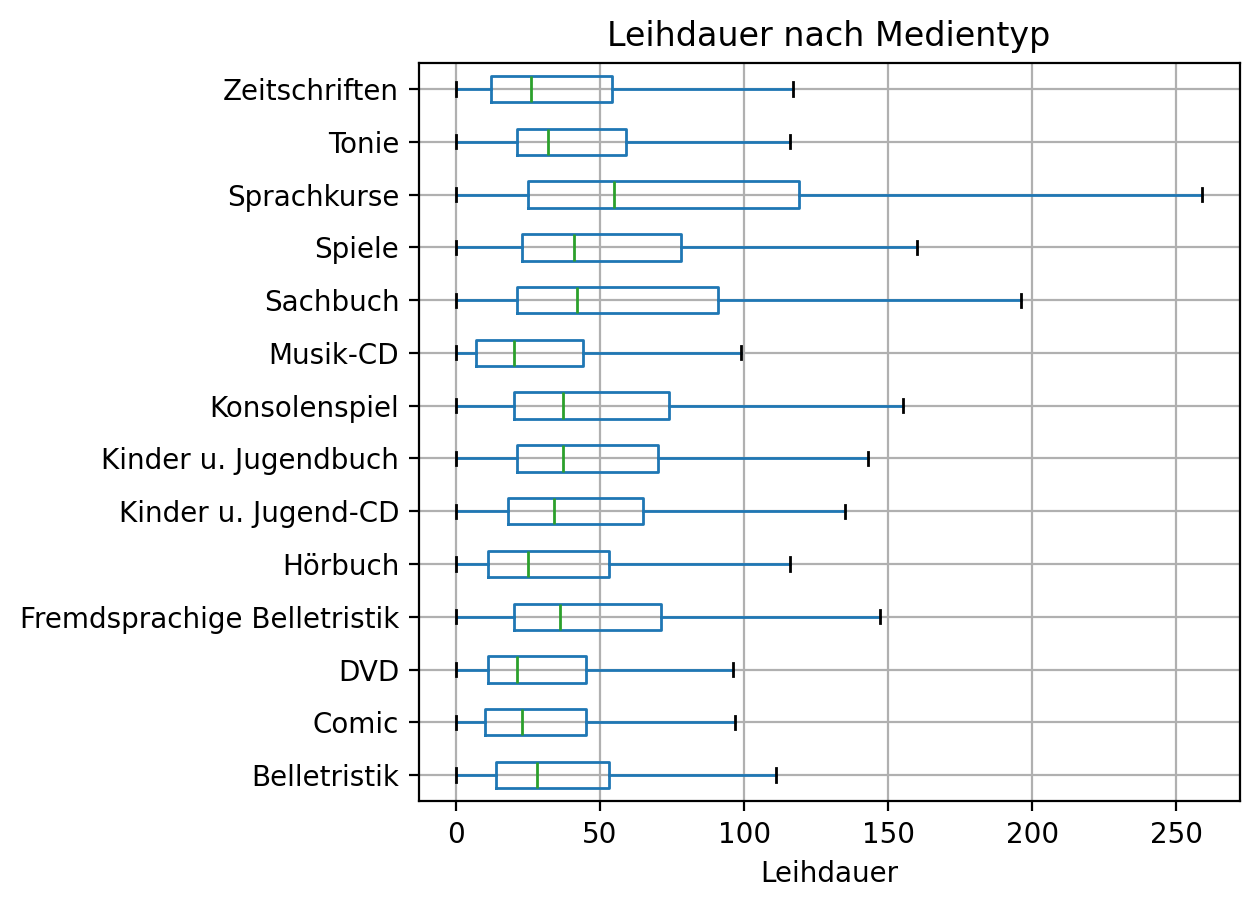

,Medientyp,mean,median,p75,p90,p95,late_rate_percent,median_late,median_on_time,delta_median
8,Musik-CD,37.717453,20.0,44.0,98.0,153.0,1.759569,93.0,19.0,74.0
13,Zeitschriften,43.396666,26.0,54.0,107.0,160.0,3.582684,93.5,25.0,68.5
11,Sprachkurse,79.730714,55.0,119.0,189.0,228.0,7.826226,119.0,51.0,68.0
9,Sachbuch,66.734031,42.0,91.0,167.0,202.0,5.373545,98.0,41.0,57.0
3,Fremdsprachige Belletristik,55.514052,36.0,71.0,129.0,175.0,4.562248,81.0,35.0,46.0
4,Hörbuch,41.902801,25.0,53.0,103.0,147.0,2.343440,68.0,24.0,44.0
5,Kinder u. Jugend-CD,51.329954,34.0,65.0,116.0,162.0,2.999693,68.0,33.0,35.0
10,Spiele,59.983576,41.0,78.0,140.0,183.0,5.320884,72.5,40.0,32.5
1,Comic,35.815630,23.0,45.0,83.0,120.0,2.878910,52.0,22.0,30.0
0,Belletristik,42.565095,28.0,53.0,96.0,135.0,2.605181,55.0,27.0,28.0


In [10]:
leihdauer_stats = (
    data_frame
    .groupby("Medientyp")["Leihdauer"]
    .agg(
        mean="mean",
        median="median",
        p75=lambda x: x.quantile(0.75),
        p90=lambda x: x.quantile(0.90),
        p95=lambda x: x.quantile(0.95),
    )
    .reset_index()
)

late_rate = (
    data_frame
    .groupby("Medientyp")["Verspätet"]
    .apply(lambda x: (x == "Ja").mean() * 100)
    .rename("late_rate_percent")
)

leihdauer_by_late = (
    data_frame
    .groupby(["Medientyp", "Verspätet"])["Leihdauer"]
    .median()
    .unstack()
    .rename(columns={"Ja": "median_late", "Nein": "median_on_time"})
)

leihdauer_by_late["delta_median"] = (
        leihdauer_by_late["median_late"]
        - leihdauer_by_late["median_on_time"]
)

media_type_table = (
    leihdauer_stats
    .set_index("Medientyp")
    .join(late_rate)
    .join(leihdauer_by_late)
    .reset_index()
    .sort_values("delta_median", ascending=False)
)

order = media_type_table["Medientyp"].tolist()

plt.figure(figsize=(10, 6))
data_frame.boxplot(
    column="Leihdauer",
    by="Medientyp",
    vert=False,
    grid=True,
    showfliers=False
)
plt.suptitle("")
plt.title("Leihdauer nach Medientyp")
plt.xlabel("Leihdauer")
plt.ylabel("")
plt.tight_layout()
plt.show()

display(media_type_table)


## Takeaways
- across all media categories, late returns are associated with longer loan durations
- in some categories extended usage periods can be considered as a relevant risk signal for late returns (categories with high "delta_median")
- in categories with low "Delta_Median", this relationship is much less pronounced, suggesting that late returns there are driven by different underlying factors.

So there is a correlation between loan duration and late returns. In some categories its more pronounced.
To show this correlation we can look at the following plot (over all categories)

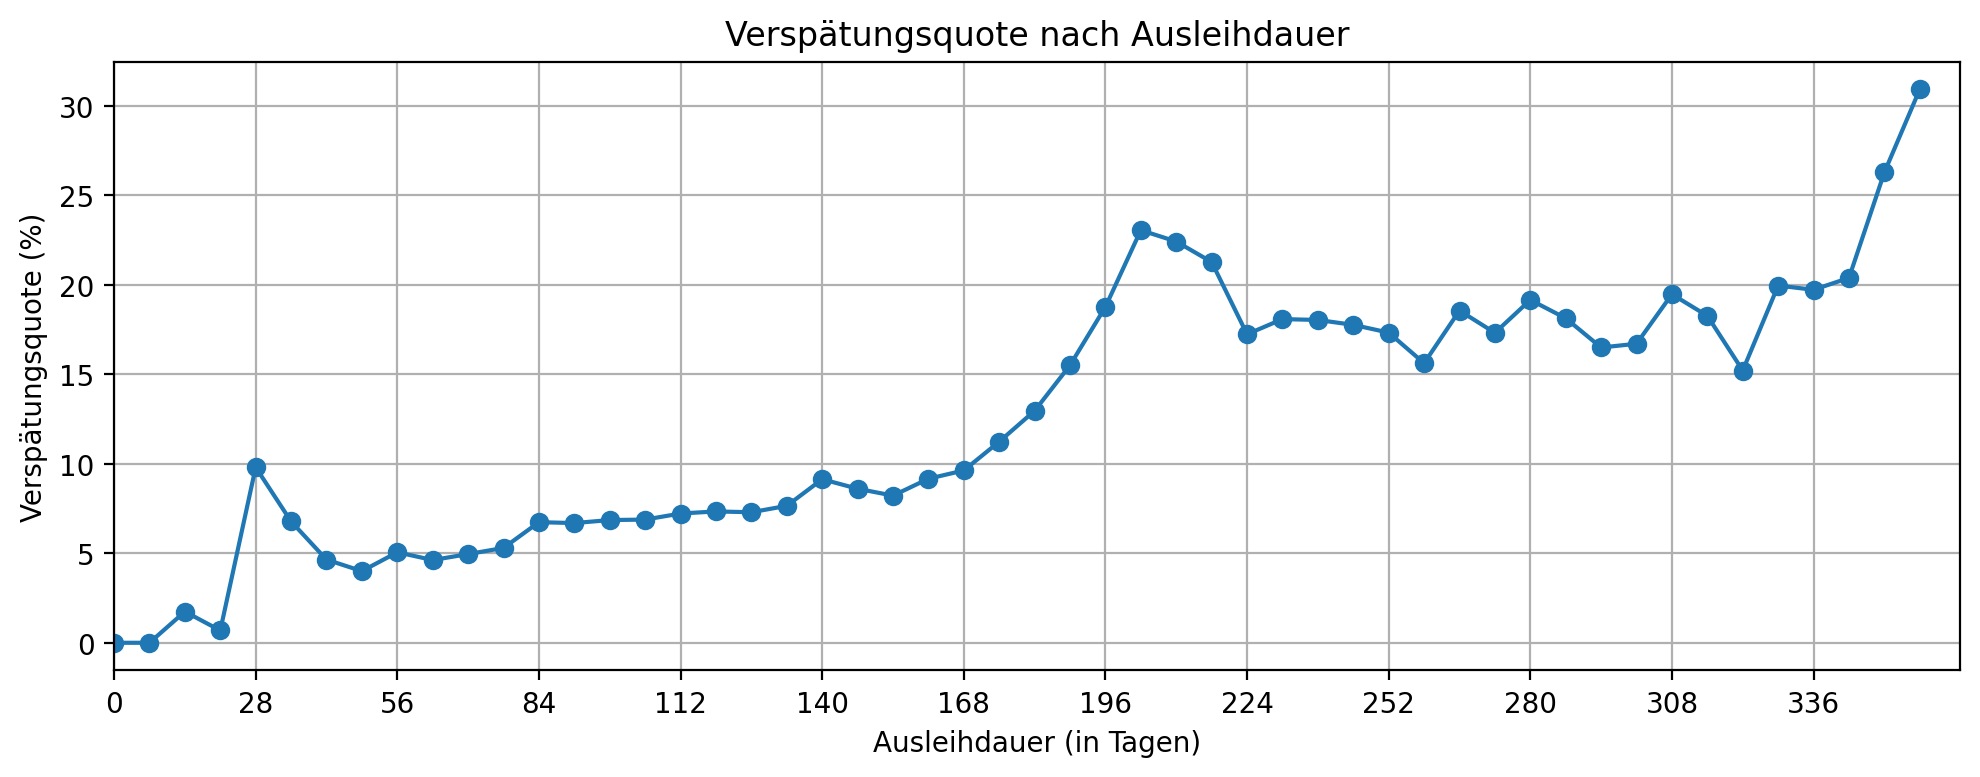

In [11]:
all_data_copy = data_frame.copy()

# bins of 7 days (for loan duration)
all_data_copy["duration_bin_7d"] = pd.cut(
    all_data_copy["Leihdauer"],
    bins=range(0, 366, 7),
    include_lowest=True
)

# Verspätungsquote pro Bin
late_rate_7d = (
    all_data_copy.groupby("duration_bin_7d", observed=False)["late_bool"]
    .mean()
    * 100
)

# Plot
x_vals = [interval.left for interval in late_rate_7d.index]
plt.figure(figsize=(10, 4))
plt.plot(x_vals, late_rate_7d.values, marker="o")

plt.xlabel("Ausleihdauer (in Tagen)")
plt.ylabel("Verspätungsquote (%)")
plt.title("Verspätungsquote nach Ausleihdauer")

plt.xticks(np.arange(0, max(x_vals) + 1, 28))
plt.xlim(0, 365)

plt.grid(True)
plt.tight_layout()
plt.show()


We can see that a longer loan duration leads to a higher delay rate. In some media types, this correlation is more pronounced (as shown in the table)

## Identifying correlations for properties of media types

To find correlations between properties of media types and late rate we look at some scatter plots.

In [12]:
media_type_table_copy = media_type_table.copy()

counts = data_frame.groupby("Medientyp").size().rename("n_loans")
media_type_table_copy = media_type_table_copy.merge(counts, on="Medientyp", how="left")

# bubble size scaling
media_type_table_copy["size"] = 50 + 400 * np.sqrt(media_type_table_copy["n_loans"] / media_type_table_copy["n_loans"].max())

figure = px.scatter(
    media_type_table_copy,
    x="mean",
    y="late_rate_percent",
    size="size",
    hover_name="Medientyp",
    hover_data={
        "n_loans": True,
        "mean": ":.2f",
        "late_rate_percent": ":.2f",
        "median": ":.2f",
        "delta_median": ":.2f",
        "size": False
    },
    labels={
        "mean": "Mean loan duration (days)",
        "late_rate_percent": "Late rate (%)",
        "n_loans": "amount of loans",
        "delta_median": "median(late) - median(on time"
    },
    title="Mean Leihdauer vs Late returns",
    trendline="ols"
)

figure.update_traces(marker=dict(opacity=0.75))
figure.update_layout(
    xaxis_title="Mean loan duration (days)",
    yaxis_title="Late rate (%)",
    width=600,
    height=600,
)

figure.show()

# calculate pearson
log_pearson_spearman(media_type_table_copy, "mean", "late_rate_percent")


mean vs late_rate_percent (n=14)
Pearson  r   = 0.7192   p = 0.00374
Spearman rho = 0.6264   p = 0.0165


### MIN_BORROWINGS_PER_MEDIA_TYPE = 1000
We see that there seems to be no correlation across media types. There is one clear outlier, **"Bibliothek der Dinge"**, which has a very high late rate but a very low median loan duration. However, with a threshold of 1,000 loans per media type, the number of loans per category may still be too small for stable estimates.

Correlation coefficients and p-values (null hypothesis: no correlation):
- Pearson r = -0.0509, p = 0.841
- Spearman rho = 0.1331, p = 0.598

### MIN_BORROWINGS_PER_MEDIA_TYPE = 5000
We increase the minimum number of loans to 5,000 per media type.

Correlation coefficients and p-values (null hypothesis: no correlation):
- Pearson r = 0.7192, p = 0.00374
- Spearman rho = 0.6264, p = 0.0165

With the increased threshold, we observe a fairly strong and approximately linear relationship between mean loan duration and late rate. This is consistent with the plot shown earlier across all media types. Loan duration therefore seems to be an indicator for late returns (at the media-type level).


In [21]:
input_data_frame = media_type_table_copy.copy()
input_data_frame["size"] = 50 + 400 * np.sqrt(input_data_frame["n_loans"] / input_data_frame["n_loans"].max())

fig = px.scatter(
    input_data_frame, x="delta_median", y="late_rate_percent", size="size",
    hover_name="Medientyp",
    hover_data={"n_loans":True, "delta_median":":.1f", "late_rate_percent":":.2f", "mean":":.1f", "size":False},
    labels={"delta_median":"delta_median (late - on time) days", "late_rate_percent":"Late rate (%)"},
    title="Late rate vs delta_median",
    trendline="ols"
)
fig.update_traces(marker=dict(opacity=0.75))
fig.update_layout(width=650, height=600)
fig.show()

log_pearson_spearman(input_data_frame, "delta_median", "late_rate_percent")


delta_median vs late_rate_percent (n=14)
Pearson  r   = -0.0706   p = 0.81
Spearman rho = -0.2134   p = 0.464


In [ ]:
input_data_frame = media_type_table_copy.copy()
input_data_frame["size"] = 50 + 400 * np.sqrt(input_data_frame["n_loans"] / input_data_frame["n_loans"].max())

fig = px.scatter(
    input_data_frame, x="p90", y="late_rate", size="size",
    hover_name="Medientyp",
    hover_data={"n_loans":True, "p90":":.1f", "late_rate":":.2f", "mean_loan_duration":":.1f", "size":False},
    labels={"p90":"P90 loan duration (days)", "late_rate":"Late rate (%)"},
    title="Late rate vs long-tail duration (P90)",
    trendline="ols"
)
fig.update_traces(marker=dict(opacity=0.75))
fig.update_layout(width=650, height=600)
fig.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

# --- 1) Start from your aggregated table ---
# If you already have plot_df with n_loans and renamed columns, use that.
# Otherwise, build it from final_table + counts:

input_data_frame = media_type_table[media_type_table["Medientyp"] != "Bibliothek der Dinge"].copy()
counts = data_frame.groupby("Medientyp").size().rename("n_loans")
input_data_frame = input_data_frame.merge(counts, on="Medientyp", how="left")

# If your columns are still named mean + late_rate_percent:
input_data_frame = input_data_frame.rename(columns={"mean": "mean_loan_duration", "late_rate_percent": "late_rate"})

# --- 2) Choose numeric features for PCA ---
# Keep this list explicit so you control what PCA "sees".
candidate_features = [
    "mean_loan_duration",
    "median",
    "p75",
    "p95",
    "late_rate",
    "delta_median",
    "n_loans"
]

features = [c for c in candidate_features if c in input_data_frame.columns]
X = input_data_frame[features].copy()

# Handle missing values (drop rows with any NA in selected features)
mask = X.notna().all(axis=1)
df_pca = input_data_frame.loc[mask].copy()
X = X.loc[mask].copy()

# --- 3) Standardize + PCA ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=0)
PC = pca.fit_transform(X_scaled)

df_pca["PC1"] = PC[:, 0]
df_pca["PC2"] = PC[:, 1]

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Explained variance total (PC1+PC2):", pca.explained_variance_ratio_.sum())

# --- 4) Bubble size like your other plots ---
df_pca["size"] = 50 + 400 * np.sqrt(df_pca["n_loans"] / df_pca["n_loans"].max())

fig = px.scatter(
    df_pca,
    x="PC1",
    y="PC2",
    size="size",
    hover_name="Medientyp",
    hover_data={c: (":.2f" if df_pca[c].dtype != "object" else True) for c in features if c != "Medientyp"} | {"size": False},
    title="PCA of Medientyp aggregated features (PC1 vs PC2)",
)
fig.update_traces(marker=dict(opacity=0.75))
fig.update_layout(width=700, height=600)
fig.show()

# --- 5) Loadings: which features drive PC1 / PC2 ---
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=["PC1_loading", "PC2_loading"]
).sort_values("PC1_loading", key=lambda s: s.abs(), ascending=False)

display(loadings)


## Analysis of extensions and late returns
Another interesting data point are the amount of the extensions. Is there a correlation to late returns?
First we look at the basic properties.

In [ ]:
base_table = (
    data_frame
    .assign(
        late =data_frame["Verspätet"] == "Ja",
        has_extension =data_frame["Anzahl_Verlängerungen"] > 0
    )
)

per_media_type_table = (
    base_table
    .groupby("Medientyp")
    .agg(
        n_loans=("Leihdauer", "size"),
        mean_extensions=("Anzahl_Verlängerungen", "mean"),
        median_extensions=("Anzahl_Verlängerungen", "median"),
        max_extensions=("Anzahl_Verlängerungen", "max"),
        pct_with_extension=("has_extension", "mean"),
        late_rate=("late", "mean"),
    )
    .reset_index()
    .assign(
        pct_with_extension=lambda df: (df["pct_with_extension"] * 100).round(2),
        late_rate=lambda df: (df["late_rate"] * 100).round(2),
    )
    .sort_values("late_rate", ascending=False)
)

overall_row = pd.DataFrame([{
    "": "Gesamt",
    "n_loans": base_table["Leihdauer"].size,
    "mean_extensions": base_table["Anzahl_Verlängerungen"].mean(),
    "median_extensions": base_table["Anzahl_Verlängerungen"].median(),
    "max_extensions": base_table["Anzahl_Verlängerungen"].max(),
    "pct_with_extension": base_table["has_extension"].mean(),
    "late_rate": base_table["late"].mean(),
}])

display(per_media_type_table)
display(
    overall_row
    .assign(
        pct_with_extension=lambda df: (df["pct_with_extension"] * 100).round(2),
        late_rate=lambda df: (df["late_rate"] * 100).round(2),
    )
    .style.set_properties(**{"font-weight": "bold" })
)


There are many extensions in the max_extensions column, and the range across media types is quite large. To visualize the distribution of extensions, we use a bar chart.

We group the number of extensions into the following bins: 1, 2, 3, 4, 5, 6, 7–10, >50.

In [ ]:
extension_data_frame = data_frame.copy()

# create the bins (cutoff points)
bins   = [-0.1, 0, 1, 2, 3, 4, 5, 6, 10, float("inf")]
labels = ["0", "1", "2", "3", "4", "5", "6", "7–10", ">10"]

# add column for bins
extension_data_frame["extension_bin"] = pd.cut(
    extension_data_frame["Anzahl_Verlängerungen"],
    bins=bins,
    labels=labels,
    include_lowest=True,
)

# count media types per bin
distribution_per_media_type = (
    extension_data_frame
    .groupby(["Medientyp", "extension_bin"], observed=True)
    .size()
    .unstack(fill_value=0)
)

# share per media type
distribution_per_media_type = distribution_per_media_type.div(distribution_per_media_type.sum(axis=1), axis=0)

# bar chart
ax = distribution_per_media_type.plot(kind="bar", stacked=True, figsize=(12, 5), colormap="tab20")
plt.ylabel("Share of loans")
plt.title("Amount of extensions by media-type")
plt.legend(title="Extensions", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


The chart shows that most loans fall into the 1–6 extension bins. Some media types, such as “Sprachkurse,” stand out with comparatively high numbers of extensions. This is likely because language courses are often used over a longer period and require a lot of work and practice, which makes renewals more common.

The next step is to find correlations between extensions and late returns per media type. To get a first impression we look at a scatter plot with the late return rate per

In [ ]:
extension_data_frame["late"] = (extension_data_frame["Verspätet"] == "Ja").astype(int)

late_rate_by_extensions = (
    extension_data_frame.groupby("Anzahl_Verlängerungen")["late"]
    .agg(n="size", late_rate="mean")
    .reset_index()
    .sort_values("Anzahl_Verlängerungen")
)

x = late_rate_by_extensions["Anzahl_Verlängerungen"].to_numpy()
y = late_rate_by_extensions["late_rate"].to_numpy()
n = late_rate_by_extensions["n"].to_numpy()

fig, ax = plt.subplots(figsize=(14, 4), constrained_layout=True)

c = np.log10(n)

scatter = ax.scatter(x, y, c=c, s=60, cmap="turbo")
ax.plot(x, y, alpha=0.35)

ax.set_xlabel("Anzahl Verlängerungen")
ax.set_ylabel("Anteil verspätet")
ax.set_xlim(left=0, right=x.max())
ax.margins(x=0)
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(0, x.max() + 1, 5))

color_bar = plt.colorbar(scatter, ax=ax)
color_bar.set_label("Anzahl Ausleihen pro Anzahl Verlängerungen (log)")

plt.show()

At first glance, the plot does not indicate a meaningful correlation. The fluctuations become larger as the number of borrowings decreases, and the tail with very few borrowings looks particularly unusual.

Most borrowings fall between 1 and 6 extensions, so we should examine this range in more detail

In [ ]:
# look at smaller range (categories of extension from above)
categorized_extension_data = extension_data_frame.copy()

categorized_extension_data["extensions_bin"] = pd.cut(
    categorized_extension_data["Anzahl_Verlängerungen"],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

late_rate_by_category = (
    categorized_extension_data.groupby("extensions_bin", observed=True)["late"]
    .agg(n="size", late_rate="mean")
    .reindex(labels)
    .reset_index()
)

x_labels = late_rate_by_category["extensions_bin"].astype(str).to_numpy()
x = late_rate_by_extensions["Anzahl_Verlängerungen"].to_numpy()
y = late_rate_by_category["late_rate"].to_numpy()
n = late_rate_by_category["n"].to_numpy()

fig, ax = plt.subplots(figsize=(14, 4), constrained_layout=True)

c = np.log10(n)
scatter = ax.scatter(np.arange(len(x_labels)), y, c=c, s=80, cmap="turbo")
ax.plot(np.arange(len(x_labels)), y, alpha=0.35)

ax.set_xlabel("Anzahl Verlängerungen (Kategorien)")
ax.set_ylabel("Anteil verspätet")
ax.set_ylim(0, 1)
ax.set_xlim(left=0)
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels)

color_bar = plt.colorbar(scatter, ax=ax)
color_bar.set_label("Anzahl Ausleihen pro Kategorie (log)")

plt.show()

A closer look at the lower range of extension counts does not reveal any meaningful insights. The late-return rate appears constant, with only a small spike in segments where the number of observations is low.

But maybe there is a correlation when we look at the media types. To explore this, we use a scatter plot with the percentage of loans with extensions on the x-axis and the late-return rate on the y-axis. Bubble size is proportional to the number of loans for each media type.

In [ ]:
per_media_type_data = per_media_type_table.copy()

def show_per_media_type_scatter_plot(input_data_frame):
    input_data_frame["size"] = 50 + 400 * np.sqrt(input_data_frame["n_loans"] / input_data_frame["n_loans"].max())
    figure = px.scatter(
        input_data_frame,
        x="pct_with_extension",
        y="late_rate",
        size="size",
        hover_name="Medientyp",
        hover_data={
            "n_loans": True,
            "pct_with_extension": ":.2f",
            "late_rate": ":.2f",
            "size": False
        },
        labels={
            "pct_with_extension": "Percent with extension",
            "late_rate": "Late rate",
            "n_loans": "amount fo loans"
        },
        title="Extensions vs Late returns",
        trendline="ols"
    )

    figure.update_traces(marker=dict(opacity=0.75))
    figure.update_layout(
        xaxis_title="Percentage with extension (%)",
        yaxis_title="Late rate (%)",
        width=600,
        height=600,
    )

    figure.show()

show_per_media_type_scatter_plot(per_media_type_data)


This looks quite interesting. “Bibliothek der Dinge” stands out as a strong outlier, while the remaining media types appear to follow a fairly linear pattern. In the next step, we exclude “Bibliothek der Dinge” and revisit the plot. We also compute the Pearson correlation coefficient.

In [ ]:
table_without_bdd = per_media_type_table[per_media_type_table["Medientyp"] != "Bibliothek der Dinge"].copy()

x = table_without_bdd["pct_with_extension"].to_numpy()
y = table_without_bdd["late_rate"].to_numpy()

pearson_coefficient = np.corrcoef(x, y)[0, 1]

print(f"Pearson r: {pearson_coefficient:.3f}")
show_per_media_type_scatter_plot(table_without_bdd)

So we can see a linear relationship across media types. Media types with higher percentage of loans that get extended tend to have a higher late-return rate.

But does the amount of extensions matter for the relationship?


In [ ]:
extensions_without_bdd = extension_data_frame[extension_data_frame["Medientyp"] != "Bibliothek der Dinge"].copy()
extensions_without_bdd["late"] = (extensions_without_bdd["Verspätet"] == "Ja").astype(int)

ks = [1, 2, 3, 4, 5, 6, 10]

per_media = extensions_without_bdd.groupby("Medientyp").agg(
    n_loans=("issue_id", "size"),
    late_rate=("late", "mean"),
).reset_index()

for k in ks:
    per_media[f"pct_ext_ge_{k}"] = (
        extensions_without_bdd.assign(flag=extensions_without_bdd["Anzahl_Verlängerungen"] >= k)
        .groupby("Medientyp")["flag"].mean()
        .values
    )

# in %
per_media["late_rate"] *= 100
for k in ks:
    per_media[f"pct_ext_ge_{k}"] *= 100

# correlations
for k in ks:
    x = per_media[f"pct_ext_ge_{k}"].to_numpy()
    y = per_media["late_rate"].to_numpy()
    pear = np.corrcoef(x, y)[0, 1]
    spear = pd.Series(x).corr(pd.Series(y), method="spearman")
    print(f">={k}: Pearson r={pear:.3f} | Spearman ρ={spear:.3f}")


# look at extended only, remove outliers
df_ext = extensions_without_bdd[
    (extensions_without_bdd["Anzahl_Verlängerungen"] >= 1) &
    (extensions_without_bdd["Anzahl_Verlängerungen"] <= 10)
    ].copy()


mean_median_ext = (
    df_ext.groupby("Medientyp")["Anzahl_Verlängerungen"]
    .agg(mean_extensions="mean", median_extensions="median", n_extenders="size")
    .reset_index()
    .sort_values("n_extenders", ascending=False)
)

media_type_table_copy = (
    per_media[["Medientyp", "late_rate", "n_loans"]]
    .merge(mean_median_ext[["Medientyp", "mean_extensions", "n_extenders"]], on="Medientyp", how="left")
)

fig = px.scatter(
    media_type_table_copy,
    x="mean_extensions",
    y="late_rate",
    size="n_loans",
    size_max=40,
    hover_name="Medientyp",
    hover_data={
        "n_loans": True,
        "n_extenders": True,
        "mean_extensions": ":.2f",
        "late_rate": ":.2f",
    },
    labels={
        "mean_extensions": "Mean # extensions (only extended loans, <=10)",
        "late_rate": "Late rate (%)",
        "n_loans": "Loans (n)",
        "n_extenders": "Extended loans (n)"
    },
    title="Late rate vs mean extensions (per media type)",
    trendline="ols"
)

fig.update_layout(width=600, height=600)
fig.show()

x = media_type_table_copy["mean_extensions"].to_numpy()
y = media_type_table_copy["late_rate"].to_numpy()

mask = np.isfinite(x) & np.isfinite(y)   # drop NaN/inf
pearson_r = np.corrcoef(x[mask], y[mask])[0, 1]

print(f"Pearson r (mean_extensions vs late_rate): {pearson_r:.3f}")


## Analysis of days to late and late returns
Another interesting property of a borrowing is the amount of days it is returned late. Is there a correlation to late returns?

First we look at a basic table of properties regarding the amount of days an object was returned late.

### Column descriptions (days-late summary by media type)
- **relative_lateness_if_late**
  mean days late (if late) divided by the loan duration
- **mean_days_late_if_late**
  Average number of days late, conditional on the loan being late.
- **median_days_late_if_late**
  Median number of days late, conditional on the loan being late.
- **p75_days_late**
  75th percentile of days late **among late loans only**
- **p90_days_late**
  90th percentile of days late **among late loans only**
- **mean_days_late_per_loan_duration (%)**
  Average ratio of days late to total loan duration, expressing lateness relative to how long items were borrowed.

In [ ]:
def p75_if_late(series):
    numeric_series = pd.to_numeric(series, errors="coerce")
    numeric_series = numeric_series[numeric_series > 0]
    return np.percentile(numeric_series, 75) if len(numeric_series) > 0 else 0.0

def p90_if_late(series):
    numeric_series = pd.to_numeric(series, errors="coerce")
    numeric_series = numeric_series[numeric_series > 0]
    return np.percentile(numeric_series, 90) if len(numeric_series) > 0 else 0.0


days_late_table = (
    data_frame
    .assign(
        late=lambda df: df["Verspätet"] == "Ja",
        days_late=lambda df: df["Tage_zu_spät"].clip(lower=0),
        days_late_per_loan_duration=lambda df: df["Tage_zu_spät"].clip(lower=0) / df["Leihdauer"],
        rel_late=lambda df: np.where(df["Leihdauer"] > 0, df["Tage_zu_spät"].clip(lower=0) / df["Leihdauer"],np.nan
                                     ),
    )
    .groupby("Medientyp")
    .agg(
        n_loans=("Leihdauer", "size"),

        late_rate=("late", "mean"),

        # basic properties
        mean=("days_late", "mean"),
        median=("days_late", "median"),
        max_days_late=("days_late", "max"),

        relative_lateness_if_late=("rel_late", lambda x: x[x > 0].mean()),

        # if late
        mean_days_late_if_late=("days_late", lambda x: x[x > 0].mean()),
        median_days_late_if_late=("days_late", lambda x: x[x > 0].median()),
        p75_days_late=("Tage_zu_spät", p75_if_late),
        p90_days_late=("Tage_zu_spät", p90_if_late),

        # relative lateness
        mean_days_late_per_loan_duration=("days_late_per_loan_duration", "mean")

    )
    .reset_index()
    .assign(
        late_rate=lambda df: (df["late_rate"] * 100).round(2),
        mean_days_late_per_loan_duration=lambda df: (df["mean_days_late_per_loan_duration"] * 100).round(2),
        relative_lateness_if_late=lambda df: (df["relative_lateness_if_late"] * 100).round(2),
    )
    .sort_values("late_rate", ascending=False)
)

display(days_late_table)


if we look at the median of days late so when we are using a outlier resitant  metrik, we see that the amount of days late do not varii very much between the media types. Most of of the media types you can expect a late return to be 4 or 5 days late. THere are only small exceptions wiith 3 days late and 6 days late

to get a better overview we also create a boxplot for each media-type

In [ ]:
late_data = (
    data_frame
    .assign(
        late=lambda d: d["Verspätet"] == "Ja",
        days_late=lambda d: d["Tage_zu_spät"].clip(lower=0)
    )
)

late_data = late_data[late_data["days_late"] > 0].copy()

data = [late_data.loc[late_data["Medientyp"] == m, "days_late"].values for m in order]

plt.figure(figsize=(12, 6))
plt.boxplot(
    data,
    tick_labels=order,
    showfliers=False
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Tage zu spät (nur verspätete Ausleihen)")
plt.tight_layout()
plt.show()


In [ ]:
input_data_frame = days_late_table.copy()
##df = days_late_table[days_late_table["Medientyp"] != "Bibliothek der Dinge"].copy()

# sicherstellen, dass numeric
cols = [
    "n_loans",
    "late_rate",
    "mean_days_late_if_late",
    "p90_days_late",
    "mean_days_late_per_loan_duration",
]
for c in cols:
    input_data_frame[c] = pd.to_numeric(input_data_frame[c], errors="coerce")

# optional: sinnvoll filtern, damit winzige Gruppen nicht dominieren
input_data_frame = input_data_frame[input_data_frame["n_loans"] >= 100].dropna(subset=["mean_days_late_if_late"])

# y-Variable wählen:
y_col = "late_rate"   # Alternative: "p90_days_late" oder "mean_days_late_per_loan_duration"
x_col = "mean_days_late_if_late"

# expected severity score (optional)
input_data_frame["expected_days_late_per_loan"] = input_data_frame["late_rate"] * input_data_frame["mean_days_late_if_late"] / 100

# Scatter
plt.figure(figsize=(8, 5))
plt.scatter(input_data_frame[x_col], input_data_frame[y_col], s=np.sqrt(input_data_frame["n_loans"]))  # Größe ~ sqrt(n)
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"{y_col} vs {x_col} (size ~ sqrt(n_loans))")
plt.grid(True, alpha=0.3)
plt.show()

# Pearson (ungewichtet)
pearson = input_data_frame[[x_col, y_col]].corr(method="pearson").iloc[0, 1]
print("Pearson (unweighted):", pearson)

# Weighted Pearson (Gewichte = n_loans)
w = input_data_frame["n_loans"].to_numpy(dtype=float)
x = input_data_frame[x_col].to_numpy(dtype=float)
y = input_data_frame[y_col].to_numpy(dtype=float)

def weighted_corr(x, y, w):
    w = w / w.sum()
    mx = np.sum(w * x)
    my = np.sum(w * y)
    cov = np.sum(w * (x - mx) * (y - my))
    vx = np.sum(w * (x - mx) ** 2)
    vy = np.sum(w * (y - my) ** 2)
    return cov / np.sqrt(vx * vy)

print("Pearson (weighted by n_loans):", weighted_corr(x, y, w))


In [ ]:
# df = all_data_frame.copy()
input_data_frame = data_frame[data_frame["Medientyp"] != "Bibliothek der Dinge"].copy()


input_data_frame["late"] = input_data_frame["Verspätet"].eq("Ja")
input_data_frame["days_late"] = input_data_frame["Tage_zu_spät"].clip(lower=0)

# Sicherheitscheck: Leihdauer darf nicht 0 sein
input_data_frame = input_data_frame[input_data_frame["Leihdauer"] > 0].copy()

input_data_frame["rel_late"] = input_data_frame["days_late"] / input_data_frame["Leihdauer"]

per_media = input_data_frame.groupby("Medientyp").agg(
    n_loans=("Leihdauer", "size"),
    late_rate=("late", "mean"),
    rel_late_if_late=("rel_late", lambda x: x[input_data_frame.loc[x.index, "late"]].mean()),
).reset_index()

per_media["late_rate"] *= 100
per_media["rel_late_if_late"] *= 100  # in %

# Scatter: x = relative Schwere (nur wenn late), y = late_rate
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
plt.scatter(per_media["rel_late_if_late"], per_media["late_rate"],
            s=np.sqrt(per_media["n_loans"]))
plt.xlabel("rel_late_if_late (%)")
plt.ylabel("late_rate (%)")
plt.grid(True, alpha=0.3)
plt.show()

print("Pearson:", per_media[["rel_late_if_late","late_rate"]].corr().iloc[0,1])


In [ ]:
def p75_if_late(series):
    numeric_series = pd.to_numeric(series, errors="coerce")
    numeric_series = numeric_series[numeric_series > 0]
    return np.percentile(numeric_series, 75) if len(numeric_series) > 0 else 0.0

def p90_if_late(series):
    numeric_series = pd.to_numeric(series, errors="coerce")
    numeric_series = numeric_series[numeric_series > 0]
    return np.percentile(numeric_series, 90) if len(numeric_series) > 0 else 0.0


days_late_table = (
    data_frame
    .assign(
        late=lambda df: df["Verspätet"] == "Ja",
        days_late=lambda df: df["Tage_zu_spät"].clip(lower=0),
        days_late_per_loan_duration=lambda df: df["Tage_zu_spät"].clip(lower=0) / df["Leihdauer"]
    )
    .groupby("Medientyp")
    .agg(
        n_loans=("Leihdauer", "size"),

        late_rate=("late", "mean"),

        # basic properties
        mean=("days_late", "mean"),
        median=("days_late", "median"),
        max_days_late=("days_late", "max"),

        # if late
        mean_days_late_if_late=("days_late", lambda x: x[x > 0].mean()),
        median_days_late_if_late=("days_late", lambda x: x[x > 0].median()),
        p75_days_late=("Tage_zu_spät", p75_if_late),
        p90_days_late=("Tage_zu_spät", p90_if_late),

        # relative lateness
        mean_days_late_per_loan_duration=("days_late_per_loan_duration", "mean")

    )
    .reset_index()
    .assign(
        late_rate=lambda df: (df["late_rate"] * 100).round(2),
        mean_days_late_per_loan_duration=lambda df: (df["mean_days_late_per_loan_duration"] * 100).round(2),
    )
    .sort_values("late_rate", ascending=False)
)

display(days_late_table)
